<a href="https://colab.research.google.com/github/geraldomsousaj/industrial-challenge-EDF/blob/importanceFactor/3_0_geraldomsousaj_hydraulic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openturns 
import pandas as pd
import numpy as np
import openturns as ot

# 1. Simulating

In [2]:
# defining the constants
L = 5000 # length of section (m)
B = 300 # watercourse width (m)
Zb = 55.5 # shoreline elevation (m)

In [3]:
def function_flood(X):
    Q, Ks, Zv, Zm = X
    alpha = (Zm - Zv)/L
    H = (Q/(Ks * B * np.sqrt(alpha)))** (3.0/5.0) 
    S = H + Zv - Zb
    return [S]

input_dimension = 4
g = ot.PythonFunction(input_dimension , 1, function_flood)

In [4]:
# Create the marginal distributions of the parameters
dist_Q = ot.TruncatedDistribution(ot.Gumbel(558., 1013.), 0, ot.TruncatedDistribution.LOWER)
dist_Ks = ot.TruncatedDistribution(ot.Normal(30.0, 7.5), 0, ot.TruncatedDistribution.LOWER)
dist_Zv = ot.Triangular(49, 50 , 51)
dist_Zm = ot.Triangular(54, 55 , 56)

In [5]:
X = ot.ComposedDistribution([dist_Q, dist_Ks, dist_Zv, dist_Zm])
inputRV = ot.RandomVector(X)

In [6]:
# Run simulations
N = 100000
S = []
for i in range(N):
    S.append(function_flood(inputRV.getRealization()))

In [7]:
S_df = pd.DataFrame(S, columns=['S'])
print('% of positive values: ' + str(S_df[S_df['S'] > 0].shape[0] / N *100)+"%")

% of positive values: 1.18%


In [8]:
df2 = S_df[S_df['S'] > 0]  

In [9]:
df2.sort_values(by='S', ascending=False).head(20)

,S
44871,26.261403
31510,19.380357
69886,12.032397
53839,9.960293
37320,9.552282
11143,8.449689
53743,7.441275
85957,7.385330
97123,6.827439
95301,5.584294


In [10]:
q = [0.95, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 0.996, 0.997, 0.998]
for i in q:
    print('Quantile {}%: {:0.4f}'.format(i*100, df2.quantile(i).S))


Quantile 95.0%: 2.5694
Quantile 96.0%: 2.8290
Quantile 96.5%: 2.9600
Quantile 97.0%: 3.2717
Quantile 97.5%: 3.5275
Quantile 98.0%: 3.9323
Quantile 98.5%: 4.1829
Quantile 99.0%: 5.0585
Quantile 99.5%: 7.5472
Quantile 99.6%: 8.7628
Quantile 99.7%: 9.7412
Quantile 99.8%: 11.2906


# 2. Distribution Fit

##### P(EXTREME EVENT) = 1 - F(THRESHOLD) #####
dweibull  :  0.6411579767591657 %
exponweib  :  1.0787971240006078 %
frechet_r  :  3.302447772259798 %
gumbel_r  :  2.3727923839858223 %
gumbel_l  :  11.616407747012381 %
invweibull  :  1.9847405052455747 %
(4.146226459660971, 1.7166136949009747, -6.256661709254427, 2.2144399455549544)


Text(0, 0.5, 'Frequency')

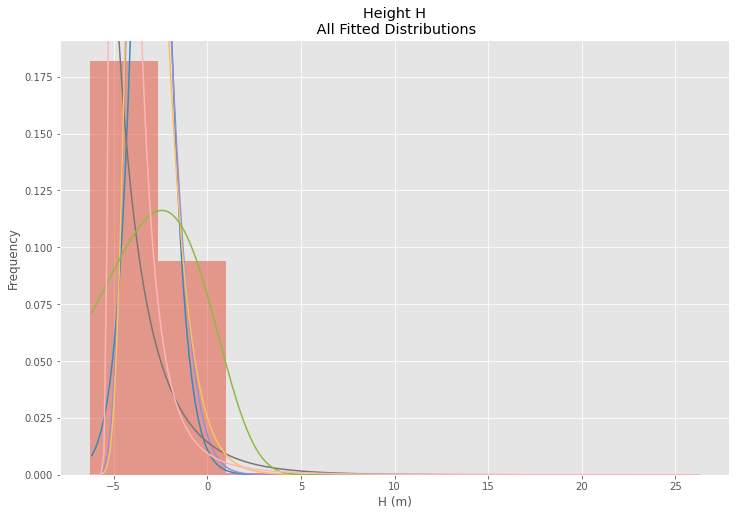

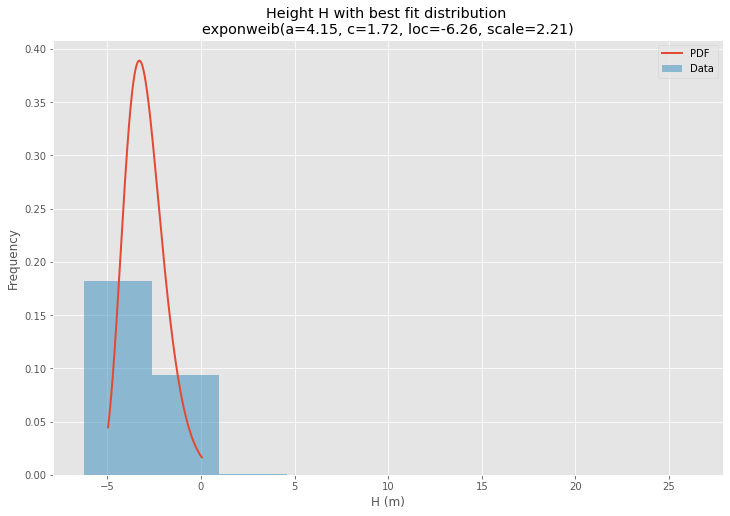

In [34]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

print('##### P(EXTREME EVENT) = 1 - F(THRESHOLD) #####')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.dweibull,
        st.exponweib,
        st.frechet_r,
        st.gumbel_r,
        st.gumbel_l,
        st.invweibull
    ]

    # DISTRIBUTIONS = [st.gumbel_r, st.gumbel_l]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass
                
                # print parameters and cdf for extreme events : P(S > THRESHOLD)
                cdf = distribution.cdf(0, loc=loc, scale=scale, *arg)

                print(distribution.name, ' : ', (1-cdf)*100, '%')

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """
    print(params)
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data 
data = S_df['S']

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=9, alpha=0.5, density=True, lw=2)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Height H\n All Fitted Distributions')
ax.set_xlabel(u'H (m)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

weights = np.ones_like(data)/float(len(data))

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=9, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Height H with best fit distribution \n' + dist_str)
ax.set_xlabel(u'H (m)')
ax.set_ylabel('Frequency')